<center><h2>Data Challenge 1: Employee Retention</h2></center>

<center><h3>Shujian Liu, Insight Data Fellow</h3></center>

## 1. Introduction

Employee turn-over is a very costly problem for companies. In this challenge, machine learning models are used to predict when employees are going to quit by understanding the main drivers of employee churn.

## 2. Preprocessing Data

### (1) Load data

In [1]:
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import math
import seaborn as sns

df = pd.read_csv('employee_retention_data.csv')

df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [2]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


### Discussion:

There is no missing value in the table. There are 7 columns and 24702 rows in the dataset. There are obviously some incorrect numbers. For example maximum value of seniority is 99.

### (2) Add feature

In [3]:
### Number of days in the company
days = []

for index, row in df.iterrows():
    date_start = datetime.strptime(row['join_date'], '%Y-%m-%d')
    if type(row['quit_date']) is float:
        date_end   = datetime.strptime('2015-12-13', '%Y-%m-%d')
    else:
        date_end   = datetime.strptime(row['quit_date'], '%Y-%m-%d')
    days.append((date_end - date_start).days)

df['days'] = days

# Add the targets: 0 not quit, 1 quit
y = [0 if type(row['quit_date']) is float else 1 for index, row in df.iterrows()]
df['quit'] = y

df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,426,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,1


## 3. Exploratory Data Analysis

### (a) Pairwise relationships

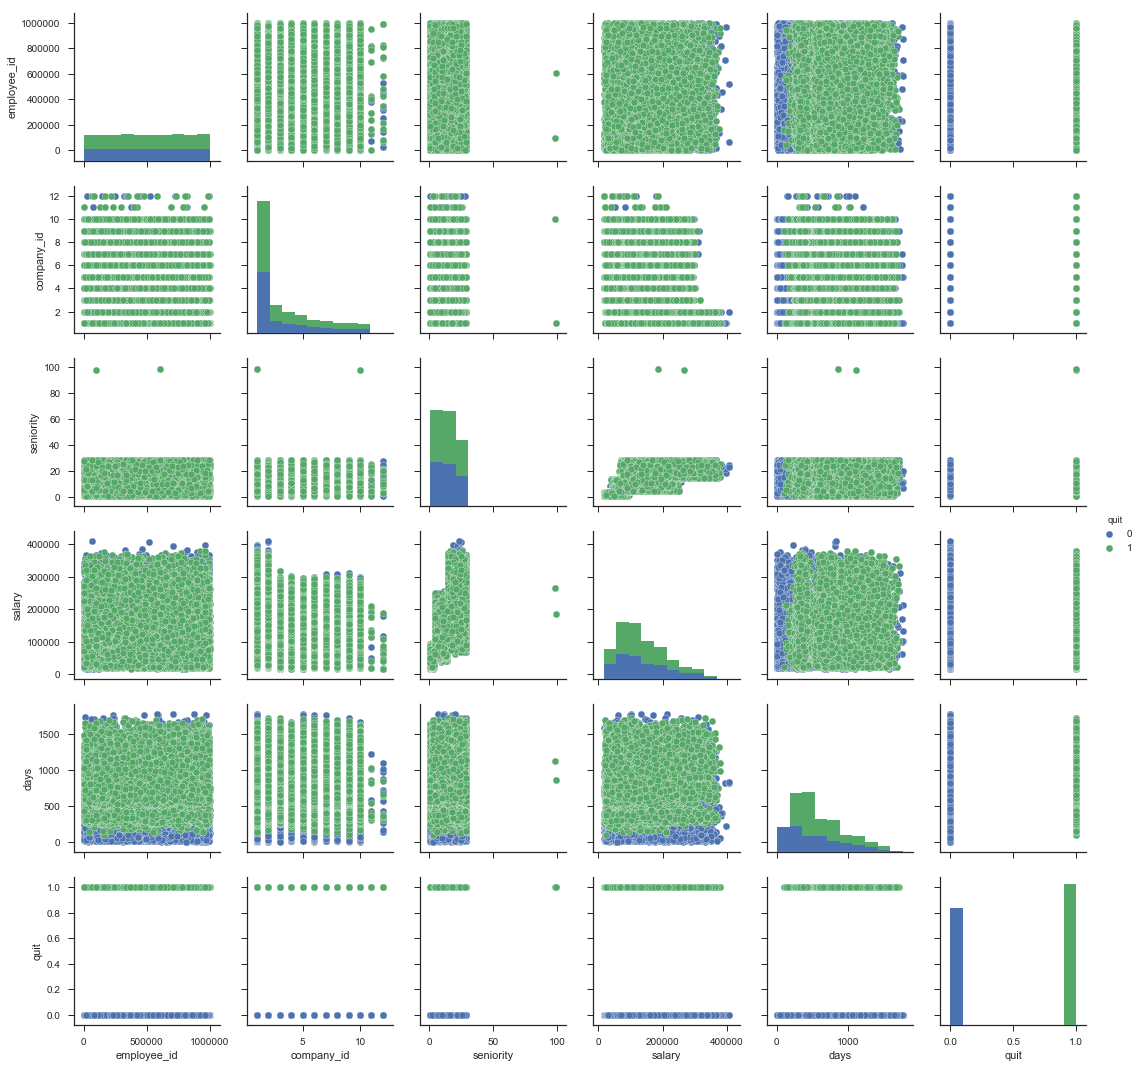

In [4]:
sns.set(style="ticks")
sns.pairplot(df, hue="quit")

In [5]:
### (b) Retention rate

In [6]:
df1 = df.groupby(df['company_id']).count()['employee_id']
df2 = df.groupby(df['company_id']).sum()['quit']
df3 = pd.concat([df1, df2], axis=1, join_axes=[df1.index])
df3.columns = ['employee_id', 'quit']
df3['rate']  = df3.apply(lambda x: x['quit'] / float(x['employee_id']), axis=1)
df3

,employee_id,quit,rate
company_id,,,
1,8486,4621,0.544544
2,4222,2206,0.522501
3,2749,1531,0.556930
4,2062,1153,0.559166
5,1755,983,0.560114
6,1291,712,0.551510
7,1224,692,0.565359
8,1047,579,0.553009
9,961,529,0.550468


### (c) Violinplot of days in each company

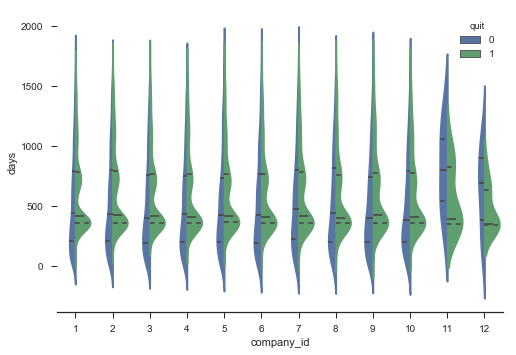

In [7]:
sns.violinplot(x="company_id", y="days", hue="quit", data=df, split=True,
               inner="quart")
sns.despine(left=True)

### (d) Boxplot of days in each company

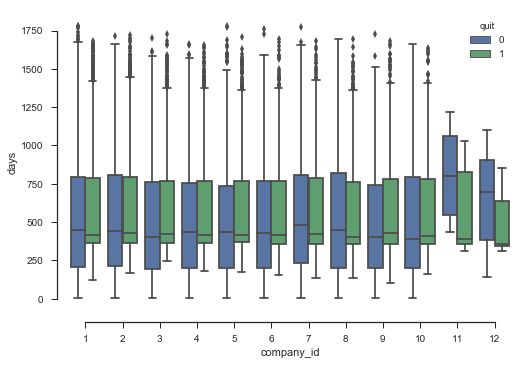

In [8]:
sns.boxplot(x="company_id", y="days", hue="quit", data=df)
sns.despine(offset=10, trim=True)

### Discussion:

From the pairwise plot, seniority and salary are corelated, which makes sense since people have long working experience tend to have higher salaries. No strong relationship between varibles and target is observed. The targets are slightly unbalanced where more people quited.

By grouping the employees together, most companies tend to have a retention rate about 55% while company 11 has much higher rate.

In the violent plot, people tend to quit around certain times: by the ends of one year or two years. 

In the box plot, it indicates that people in companies 11 and 12 tend to stay much longer.


## 4. Machine Learning

### (a) Predict whether one person will ever quit with RF

In [9]:
# One-hot encoding

df = pd.get_dummies(df, columns = ['dept'])
df = pd.get_dummies(df, columns = ['company_id'])

x_base = df.copy().drop(['quit'], axis=1)

In [10]:
x = x_base.copy()
x.drop(['employee_id', 'join_date', 'quit_date', 'days'], axis=1, inplace=True)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=2017)

clf = RandomForestClassifier()
model = clf.fit(x_train, y_train)

y_pred = clf.predict(x_valid)

print('Accuracy :')
print(sum(1 for x,y in zip(y_pred, y_valid) if x == y) / float(len(y_valid)))

# http://www.markhneedham.com/blog/2017/06/16/scikit-learn-random-forests-feature-importance/
headers = ["name", "score"]
values = sorted(zip(x.columns, model.feature_importances_), key=lambda x: x[1] * -1)

print('')
print('Feature Importance :')
for value in values:
    print(value)

Accuracy :
0.5014168128457698

Feature Importance :
('salary', 0.66600059174125259)
('seniority', 0.27301916136561127)
('company_id_1', 0.0050500305963334519)
('company_id_4', 0.0047408776430944528)
('company_id_5', 0.0044911034633091425)
('company_id_6', 0.0044498194360811389)
('company_id_9', 0.0042940698920555104)
('company_id_3', 0.0041007587162300834)
('company_id_10', 0.0040192648876108145)
('company_id_2', 0.0039567870398904362)
('company_id_7', 0.0039555409094134486)
('dept_marketing', 0.0035271818404006804)
('dept_sales', 0.0034996320258545849)
('company_id_8', 0.003307157854604492)
('dept_data_science', 0.0031322648500158022)
('dept_design', 0.0028009837584966738)
('dept_customer_service', 0.0023878770331107317)
('dept_engineer', 0.0023012242802924019)
('company_id_11', 0.00055933485370337978)
('company_id_12', 0.00040633781263895797)


### Discussion:

Clearly it is not feasible to predict whether one employee will quit or not at his/her first day. To further investigate the quesion, a new feature, days employed at this company, will be used. By adding this feature, the problem is reconsidered as: predict whether one person will quit tomorrow, which is still valuable to the company to know.

### (b)  Predict whether one person will quit tomorrow with RF

In [11]:
x = x_base.copy()
x.drop(['employee_id', 'join_date', 'quit_date'], axis=1, inplace=True)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=2017)

clf = RandomForestClassifier()
model = clf.fit(x_train, y_train)

y_pred = clf.predict(x_valid)

print('Accuracy :')
print(sum(1 for x,y in zip(y_pred, y_valid) if x == y) / float(len(y_valid)))


# http://www.markhneedham.com/blog/2017/06/16/scikit-learn-random-forests-feature-importance/
headers = ["name", "score"]
values = sorted(zip(x.columns, model.feature_importances_), key=lambda x: x[1] * -1)

print('')
print('Feature Importance :')
for value in values:
    print(value)

Accuracy :
0.7054378626366212

Feature Importance :
('days', 0.57281438405491014)
('salary', 0.22018381049646357)
('seniority', 0.134973964304132)
('company_id_1', 0.0060310197904514867)
('company_id_3', 0.0054875528850179059)
('company_id_4', 0.0054806293337384612)
('dept_sales', 0.00509170504277086)
('company_id_2', 0.0048171696228987929)
('company_id_5', 0.0047515553879806955)
('company_id_10', 0.0046090326067150678)
('company_id_6', 0.0043911143711928887)
('company_id_7', 0.0042033730179053671)
('dept_engineer', 0.0041092955383058398)
('company_id_9', 0.0041034975367145576)
('dept_marketing', 0.0040838720886927967)
('company_id_8', 0.0040643980847514301)
('dept_customer_service', 0.0035516474565261227)
('dept_data_science', 0.003376597370456163)
('dept_design', 0.003001635470930132)
('company_id_12', 0.00046237058011104365)
('company_id_11', 0.00041137495933469306)


### Discussion:

Now the accuracy is 70 percent. By looking at the feature importance outputed by random forest, days is a srong feature, followed by salary and seniority. In the next part, other classification algorithms will be test by cross-validation.

### (c) Try other classification algorithms

RF: 0.704680 (0.006914)
LR: 0.625576 (0.008368)
LDA: 0.618573 (0.010882)
KNN: 0.700510 (0.007943)
CART: 0.904785 (0.006079)
NB: 0.650311 (0.008551)
LinearSVM: 0.488219 (0.046584)


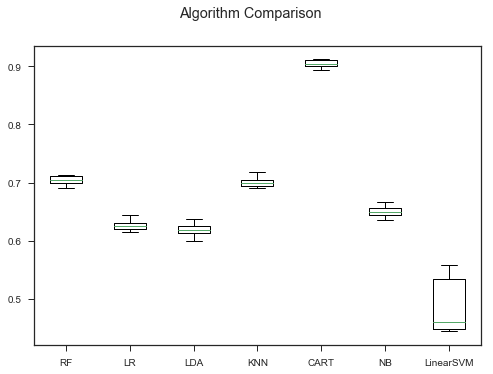

In [12]:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
# load dataset
x = x_base.copy()
x.drop(['employee_id', 'join_date', 'quit_date'], axis=1, inplace=True)
X = x.values
Y = y
# prepare configuration for cross validation test harness
seed = 2017
# prepare models
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
models.append(('LinearSVM', LinearSVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Discussion:

Supriseingly, CART/decision tree achieved an accuracy of 90%. It appears the results ensebled from multiple shallow tree is worse than a single deep tree since there are not many features in the dataset. In the next part, the decision tree model is find-tuned.

### (d) Fine-tune decision tree/CART

In [14]:
# https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

from sklearn.model_selection import GridSearchCV

x = x_base.copy()
x.drop(['employee_id', 'join_date', 'quit_date'], axis=1, inplace=True)

param_grid = {'max_depth': [3, 5, 10, 20, 50, 100, 500, 1000, 5000]}
kfolds = model_selection.KFold(n_splits=10, random_state=seed)
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kfolds)
grid_search.fit(x, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 1000}
0.904785037649


## 5. Conclusions:

Clearly it is not feasible to predict whether one employee will quit or not at his/her first day. To further investigate the quesion, a new feature, days employed at this company, will be used. By adding this feature, the problem is reconsidered as: predict whether one person will quit tomorrow, which is still valuable to the company to know.

By reforming the problem, the accuracy is 70 percent. By looking at the feature importance outputed by random forest, days is a srong feature, followed by salary and seniority. In the next part, other classification algorithms will be test by cross-validation. 

Supriseingly, CART/decision tree achieved an accuracy of 90%. It appears the results ensebled from multiple shallow tree is worse than a single deep tree since there are not many features in the dataset. In the next part, the decision tree model is find-tuned. However, fined-tuned CART model doesn't outperform the baseline algorithm. 

In the machine learning model, days is the main driver of employee churn.